In [1]:
from pathlib import Path


DATA_DIR = Path.cwd()  # is recursive, subdirectories are also searched for correct .csv files automatically


def get_csv(filename_snippet: str) -> Path:
    files = list(DATA_DIR.rglob(f'{filename_snippet}*.csv'))
    if files:
        return files[0]
    else:
        raise FileNotFoundError(f'No .csv file found containing "{filename_snippet}"')

# City spending on education

**Base URL for proper table layout:**

https://iv3statline.cbs.nl/#/IV3/nl/dataset/45067NED/table?dl=A7760

**URLs for each year:**

2024 = 45067NED = https://iv3statline.cbs.nl/#/IV3/nl/dataset/45067NED/table?dl=A783F

2023 = 45063NED = https://iv3statline.cbs.nl/#/IV3/nl/dataset/45063NED/table?dl=A783F

2022 = 45059NED = https://iv3statline.cbs.nl/#/IV3/nl/dataset/45059NED/table?dl=A783F

2021 = 45054NED = https://iv3statline.cbs.nl/#/IV3/nl/dataset/45054NED/table?dl=A783F

2020 = 45050NED = https://iv3statline.cbs.nl/#/IV3/nl/dataset/45050NED/table?dl=A783F

2019 = 45046NED = https://iv3statline.cbs.nl/#/IV3/nl/dataset/45046NED/table?dl=A783F

2018 = 45042NED = https://iv3statline.cbs.nl/#/IV3/nl/dataset/45042NED/table?dl=A783F

2017 = 45038NED = https://iv3statline.cbs.nl/#/IV3/nl/dataset/45038NED/table?dl=A783F

**=== everything below has different schema, not used! ===**

2016 = 45031NED = https://iv3statline.cbs.nl/#/IV3/nl/dataset/45031NED/table?dl=A783F

2015 = 45006NED = https://iv3statline.cbs.nl/#/IV3/nl/dataset/45006NED/table?dl=A783F

2014 = 45005NED = https://iv3statline.cbs.nl/#/IV3/nl/dataset/45005NED/table?dl=A783F

2013 = 45004NED = https://iv3statline.cbs.nl/#/IV3/nl/dataset/45004NED/table?dl=A783F

2012 = 45001NED = https://iv3statline.cbs.nl/#/IV3/nl/dataset/45001NED/table?dl=A783F

2011 = 45008NED = https://iv3statline.cbs.nl/#/IV3/nl/dataset/45008NED/table?dl=A783F

2010 = 45007NED = https://iv3statline.cbs.nl/#/IV3/nl/dataset/45007NED/table?dl=A783F

In [2]:
from expenditure import get_expenses_df


get_expenses_df(DATA_DIR, only_begroting=True, only_total=True)

Total
Year Gemeenten                
2017 's-Hertogenbosch  34991.0
     Aalsmeer           2971.0
     Alkmaar           16321.0
     Alphen-Chaam        575.0
     Amersfoort        25922.0
...                        ...
2024 Wormerland         1492.0
     Woudenberg         1271.0
     Zaanstad          35525.0
     Zandvoort          2332.0
     Zeist              7955.0

[751 rows x 1 columns]

<Axes: xlabel='Year', ylabel='x1000 €'>

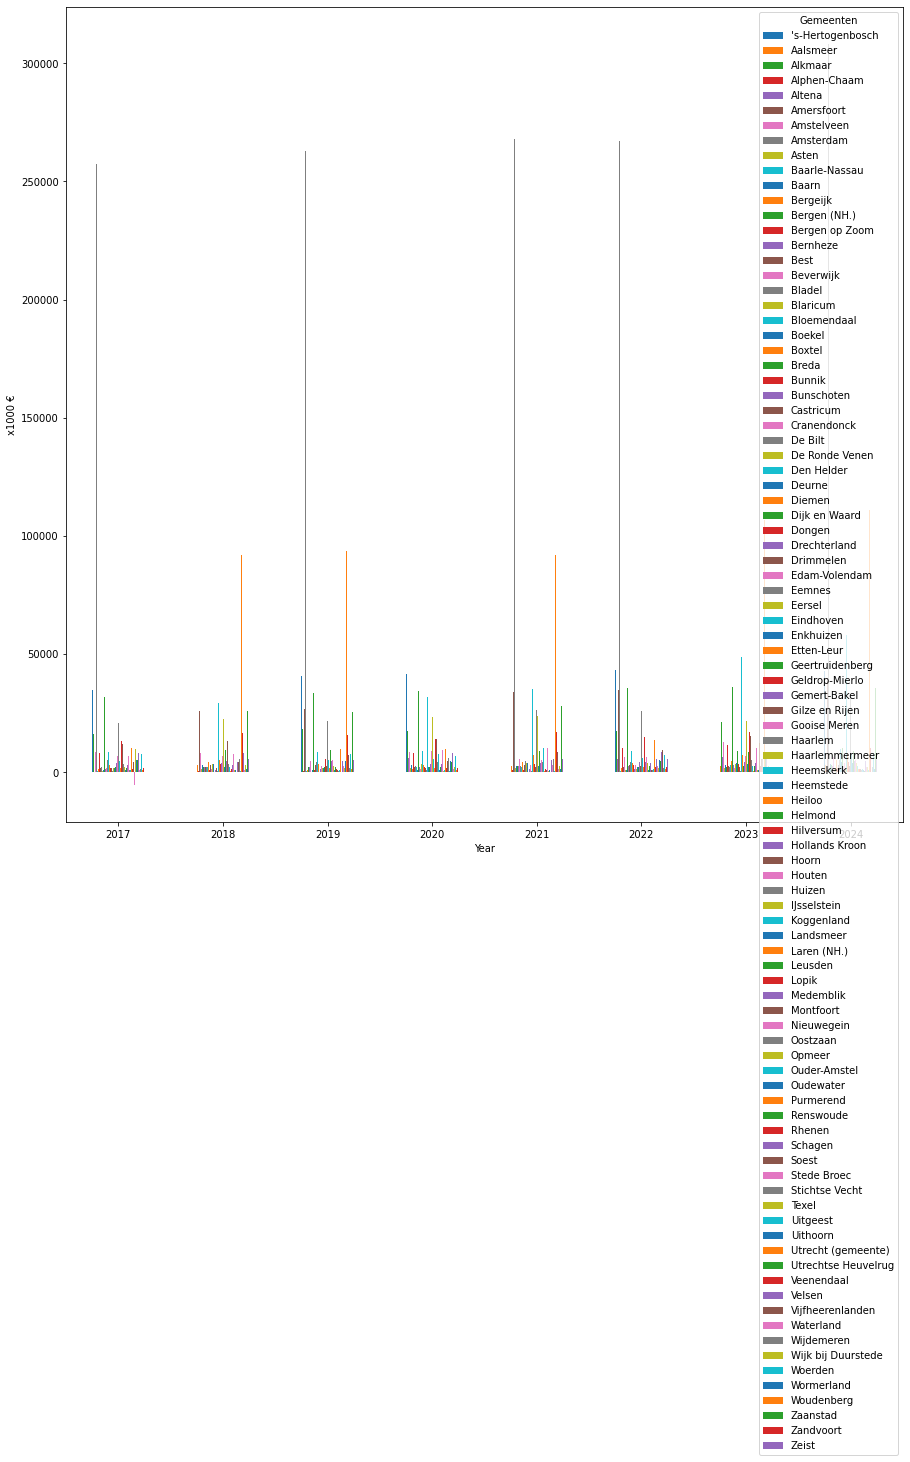

In [3]:
from expenditure import get_expenses_df, plot_expenses


ONLY_SHOW_PRED_EXPENSES = True  # useful since we don't have actual expenses data for 2023 & 2024

plot_expenses(get_expenses_df(DATA_DIR), only_show_begroting=ONLY_SHOW_PRED_EXPENSES)

# Enrollment rates

https://opendata.cbs.nl/#/CBS/nl/dataset/70072ned/table?dl=A7762

In [4]:
from enrollment import get_enrollment_df


get_enrollment_df(get_csv('Regionale_kerncijfers_'), get_csv('primary_education_'), get_csv('georef'), get_csv('enrollment-secondary'))

Total  Secondary  Primary  MBO1  MBO2  MBO Total    HBO  \
Year Gemeenten                                                               
2000 's-Graveland  196.0        NaN      NaN   NaN   NaN        NaN  128.0   
     Aalburg       161.0        NaN      NaN   NaN   NaN        NaN  125.0   
     Aalsmeer      369.0        NaN      NaN   NaN   NaN        NaN  236.0   
     Aarle-Rixtel    NaN        NaN      NaN   NaN   NaN        NaN    NaN   
     Abcoude       206.0        NaN      NaN   NaN   NaN        NaN  123.0   
...                  ...        ...      ...   ...   ...        ...    ...   
2024 Zaanstad        NaN        NaN      NaN   NaN   NaN        NaN    NaN   
     Zandvoort       NaN        NaN      NaN   NaN   NaN        NaN    NaN   
     Zeevang         NaN        NaN      NaN   NaN   NaN        NaN    NaN   
     Zeist           NaN        NaN      NaN   NaN   NaN        NaN    NaN   
     Zijpe           NaN        NaN      NaN   NaN   NaN        NaN    NaN   

                      WO  HAVO  HAVO/VWO  PRAKTIJK  VMBO  VWO  
Year Gemeenten                                                 
2000 's-Graveland   68.0   NaN       NaN       NaN   NaN  NaN  
     Aalburg        36.0   NaN       NaN       NaN   NaN  NaN  
     Aalsmeer      133.0   NaN       NaN       NaN   NaN  NaN  
     Aarle-Rixtel    NaN   NaN       NaN       NaN   NaN  NaN  
     Abcoude        83.0   NaN       NaN       NaN   NaN  NaN  
...                  ...   ...       ...       ...   ...  ...  
2024 Zaanstad        NaN   NaN       NaN       NaN   NaN  NaN  
     Zandvoort       NaN   NaN       NaN       NaN   NaN  NaN  
     Zeevang         NaN   NaN       NaN       NaN   NaN  NaN  
     Zeist           NaN   NaN       NaN       NaN   NaN  NaN  
     Zijpe           NaN   NaN       NaN       NaN   NaN  NaN  

[8573 rows x 13 columns]

<Axes: title={'center': 'Total enrollment'}, xlabel='Year', ylabel='Students'>

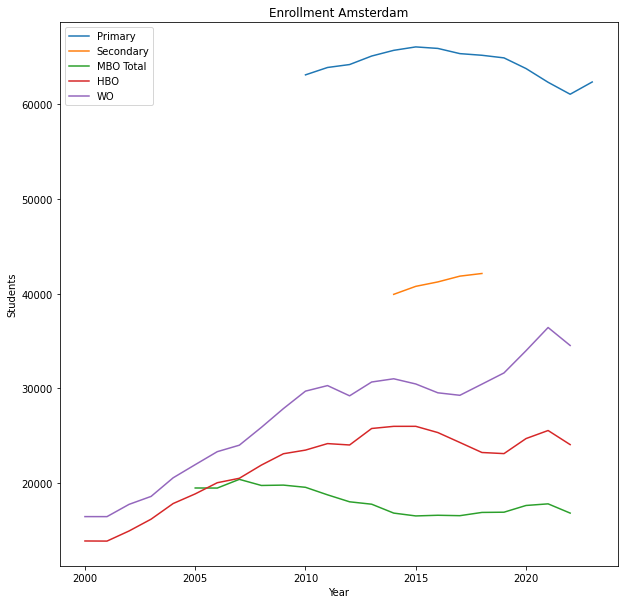

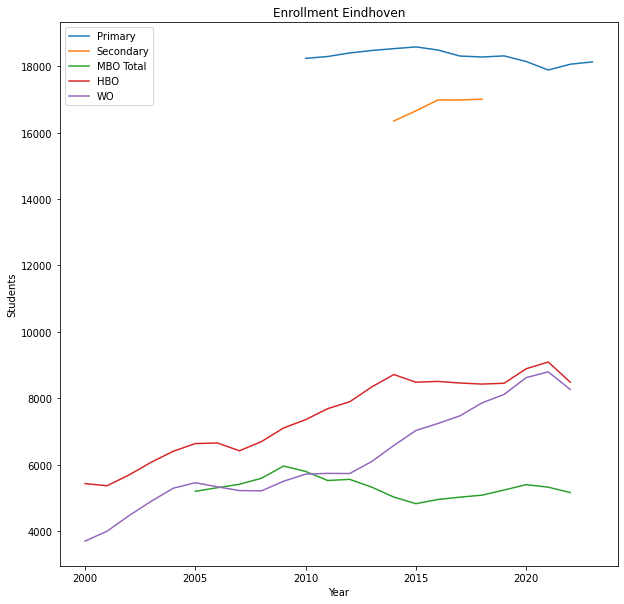

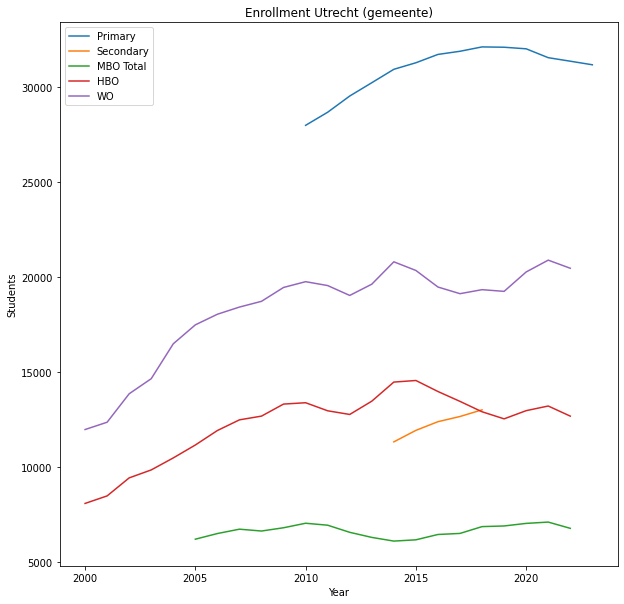

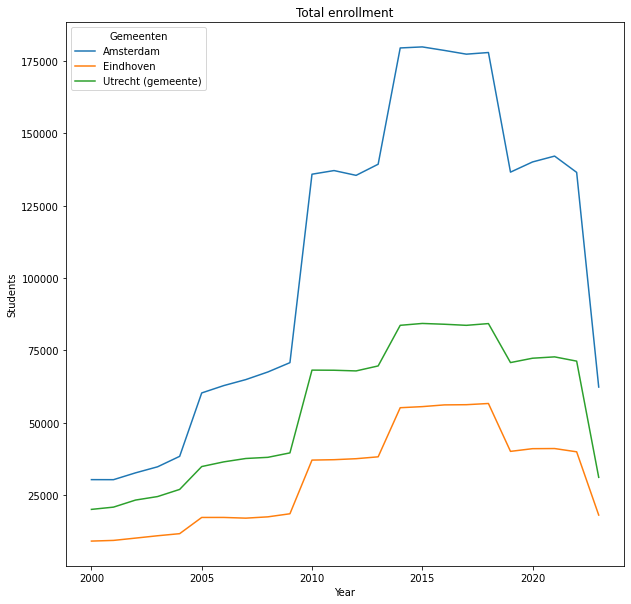

In [5]:
from enrollment import get_enrollment_df, plot_enrollment_city, plot_enrollment_total


df = get_enrollment_df(get_csv('Regionale_kerncijfers_'), get_csv('primary_education_'), get_csv('georef'), get_csv('enrollment-secondary'))

for plot in plot_enrollment_city(df, ['Utrecht (gemeente)', 'Eindhoven', 'Amsterdam'], kind='line'):
    pass  # so long as the plot is 'accessed', the notebook will display it

plot_enrollment_total(df, ['Utrecht (gemeente)', 'Eindhoven', 'Amsterdam'], kind='line')

# Socio-economic status (expressed as child poverty rate)

https://opendata.cbs.nl/statline/#/CBS/nl/dataset/85678NED/table?dl=A783E

In [6]:
from socioecon import get_poverty_df


get_poverty_df(get_csv('Laag_en_langdurig_laag_inkomen_'), only_total=True)

Minderjarige kinderen relatief
Year Gemeenten                                       
2011 's-Hertogenbosch                             8.0
     Aalsmeer                                     3.3
     Alkmaar                                      7.1
     Almelo                                       9.8
     Almere                                       9.1
...                                               ...
2022 Zeewolde                                     4.8
     Zeist                                        6.0
     Zundert                                      4.8
     Zwartewaterland                              2.2
     Zwolle                                       4.3

[1884 rows x 1 columns]

In [7]:
from merging import get_merged_df


merged_df = get_merged_df(
    DATA_DIR,
    get_csv('Regionale_kerncijfers_'), get_csv('primary_education_'), get_csv('georef'), get_csv('enrollment-secondary'),
    get_csv('Laag_en_langdurig_laag_inkomen_'),
)
merged_df

Total enrollment  Secondary  Primary  MBO1  MBO2  \
Year Gemeenten                                                        
2000 's-Graveland             196.0        NaN      NaN   NaN   NaN   
     Aalburg                  161.0        NaN      NaN   NaN   NaN   
     Aalsmeer                 369.0        NaN      NaN   NaN   NaN   
     Aarle-Rixtel               NaN        NaN      NaN   NaN   NaN   
     Abcoude                  206.0        NaN      NaN   NaN   NaN   
...                             ...        ...      ...   ...   ...   
2024 Zaanstad                   NaN        NaN      NaN   NaN   NaN   
     Zandvoort                  NaN        NaN      NaN   NaN   NaN   
     Zeevang                    NaN        NaN      NaN   NaN   NaN   
     Zeist                      NaN        NaN      NaN   NaN   NaN   
     Zijpe                      NaN        NaN      NaN   NaN   NaN   

                   MBO Total    HBO     WO  HAVO  HAVO/VWO  PRAKTIJK  VMBO  \
Year Gemeenten                                                               
2000 's-Graveland        NaN  128.0   68.0   NaN       NaN       NaN   NaN   
     Aalburg             NaN  125.0   36.0   NaN       NaN       NaN   NaN   
     Aalsmeer            NaN  236.0  133.0   NaN       NaN       NaN   NaN   
     Aarle-Rixtel        NaN    NaN    NaN   NaN       NaN       NaN   NaN   
     Abcoude             NaN  123.0   83.0   NaN       NaN       NaN   NaN   
...                      ...    ...    ...   ...       ...       ...   ...   
2024 Zaanstad            NaN    NaN    NaN   NaN       NaN       NaN   NaN   
     Zandvoort           NaN    NaN    NaN   NaN       NaN       NaN   NaN   
     Zeevang             NaN    NaN    NaN   NaN       NaN       NaN   NaN   
     Zeist               NaN    NaN    NaN   NaN       NaN       NaN   NaN   
     Zijpe               NaN    NaN    NaN   NaN       NaN       NaN   NaN   

                   VWO  Education expenses  Impoverished children  
Year Gemeenten                                                     
2000 's-Graveland  NaN                 NaN                    NaN  
     Aalburg       NaN                 NaN                    NaN  
     Aalsmeer      NaN                 NaN                    NaN  
     Aarle-Rixtel  NaN                 NaN                    NaN  
     Abcoude       NaN                 NaN                    NaN  
...                ...                 ...                    ...  
2024 Zaanstad      NaN             35525.0                    NaN  
     Zandvoort     NaN              2332.0                    NaN  
     Zeevang       NaN                 NaN                    NaN  
     Zeist         NaN              7955.0                    NaN  
     Zijpe         NaN                 NaN                    NaN  

[8631 rows x 15 columns]

In [8]:
from merging import get_cities_inner

get_cities_inner(merged_df)

Index(['Aalsmeer', 'Alkmaar', 'Amersfoort', 'Amstelveen', 'Amsterdam', 'Asten',
       'Baarn', 'Best', 'Beverwijk', 'Bladel', 'Bloemendaal', 'Boxtel',
       'Breda', 'Castricum', 'Deurne', 'Dongen', 'Eersel', 'Eindhoven',
       'Enkhuizen', 'Haarlem', 'Heemskerk', 'Heemstede', 'Heiloo', 'Hilversum',
       'Houten', 'Huizen', 'Medemblik', 'Montfoort', 'Nieuwegein', 'Purmerend',
       'Rhenen', 'Schagen', 'Soest', 'Uithoorn', 'Utrecht (gemeente)',
       'Veenendaal', 'Woerden', 'Zandvoort', 'Zeist'],
      dtype='object', name='Gemeenten')

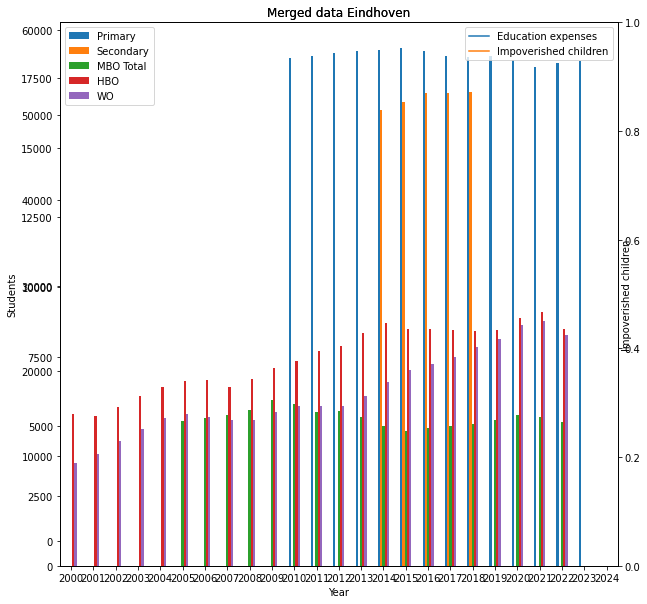

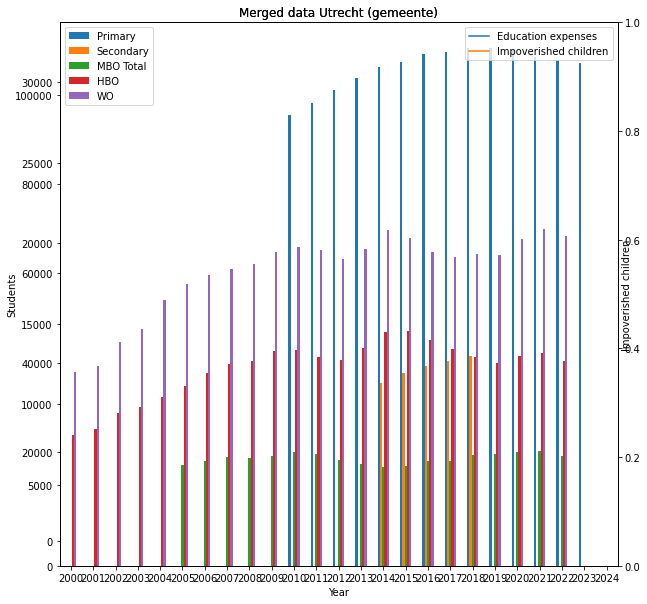

In [9]:
from merging import plot_merged_df


for plot in plot_merged_df(merged_df, cities=['Eindhoven', 'Utrecht (gemeente)']):
    pass

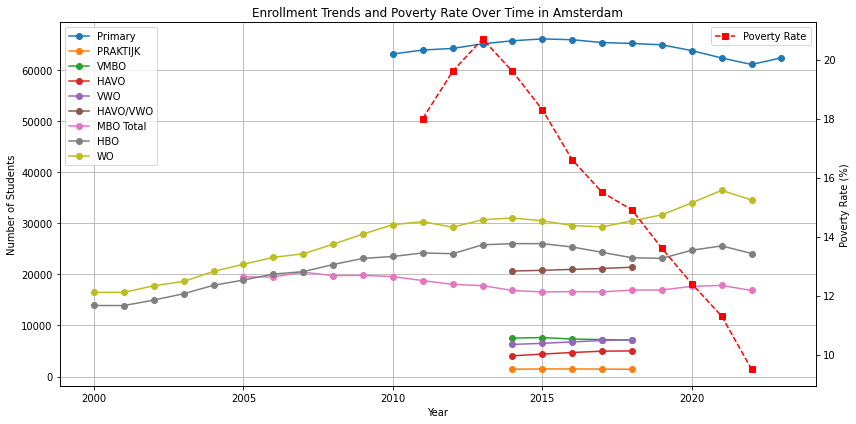

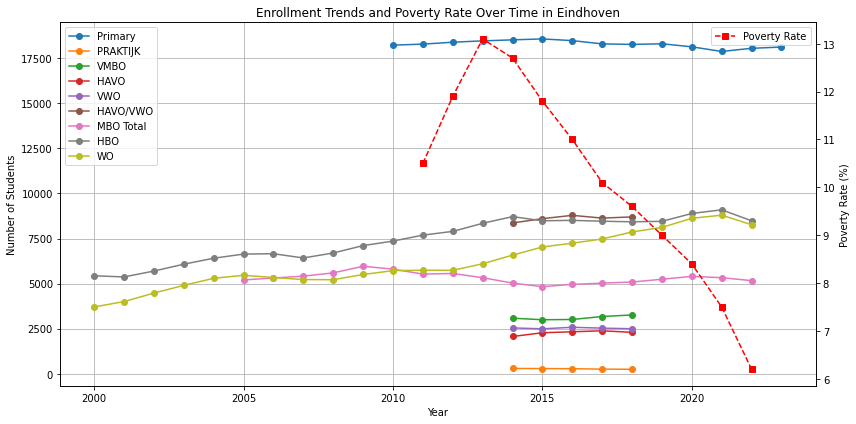

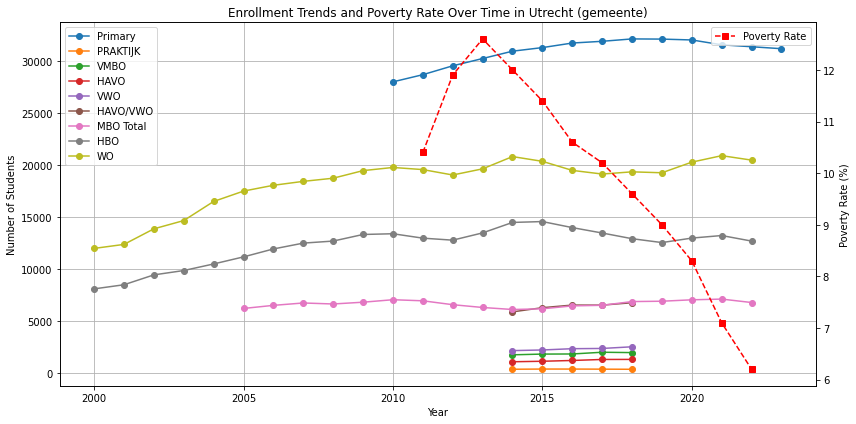

In [20]:
import matplotlib.pyplot as plt

# Define the list of cities we are interested in
target_cities = ['Amsterdam', 'Eindhoven', 'Utrecht (gemeente)']

# Filter the DataFrame to include only the target cities
filtered_df = merged_df.loc[merged_df.index.get_level_values('Gemeenten').isin(target_cities)]

# Function to create combined plots for the filtered cities
def combined_plot_trends(data, city):
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Filter data for the given city
    city_data = data.xs(city, level='Gemeenten')

    # Plot enrollment trends
    # colors = ['b', 'g', 'c', 'm', 'y', 'k']
    enrollment_types = ['Primary', 'PRAKTIJK', 'VMBO', 'HAVO', 'VWO', 'HAVO/VWO', 'MBO Total', 'HBO', 'WO', ]
    
    for i, enrollment_type in enumerate(enrollment_types):
        ax1.plot(city_data.index, city_data[enrollment_type], marker='o', label=enrollment_type)
    
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Number of Students')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    # Create a second y-axis to plot poverty rate
    ax2 = ax1.twinx()
    ax2.plot(city_data.index, city_data['Impoverished children'], marker='s', color='r', ls='--', label='Poverty Rate')
    ax2.set_ylabel('Poverty Rate (%)')
    ax2.legend(loc='upper right')
    
    plt.title(f'Enrollment Trends and Poverty Rate Over Time in {city}')
    fig.tight_layout()
    plt.show()

# Call the function for each target city in the filtered DataFrame
for city in target_cities:
    combined_plot_trends(filtered_df, city)